In [1]:
from collections import Counter
import os
import shutil
from urllib.parse import urlparse, urljoin
import ftplib
from zipfile import ZipFile
import gzip
import xml.etree.ElementTree as XML_ET
import csv
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
%matplotlib inline

## Get list of .zip batch files to download

In [2]:
BASE_URL = 'ftp://ftp.ncbi.nlm.nih.gov/pubchem/'
BIOASSAY_DATA_FOLDER = 'Bioassay/CSV/Data'  # this folder contains .CSV files with measured compounds
BIOASSAY_DESC_FOLDER = 'Bioassay/CSV/Description'  # this folder contains info about assay e.g. the target

In [3]:
parsed_url = urlparse(BASE_URL)

In [4]:
try:
    with ftplib.FTP() as ftp:
        print(ftp.connect(parsed_url.netloc))
        print(ftp.login())
        print(ftp.cwd(os.path.join(parsed_url.path, BIOASSAY_DATA_FOLDER)))
        dir_list = ftp.nlst()
        dir_list_sizes = [x for x in ftp.mlsd(facts = ["type", "size"])]
except Exception as e:
    print(e)

220-
 This warning banner provides privacy and security notices consistent with 
 applicable federal laws, directives, and other federal guidance for accessing 
 this Government system, which includes all devices/storage media attached to 
 this system. This system is provided for Government-authorized use only. 
 Unauthorized or improper use of this system is prohibited and may result in 
 disciplinary action and/or civil and criminal penalties. At any time, and for 
 any lawful Government purpose, the government may monitor, record, and audit 
 your system usage and/or intercept, search and seize any communication or data 
 transiting or stored on this system. Therefore, you have no reasonable 
 expectation of privacy. Any communication or data transiting or stored on this 
 system may be disclosed or used for any lawful Government purpose.
220 FTP Server ready.
230 Anonymous access granted, restrictions apply
250 CWD command successful


In [5]:
dir_list[:10]

['0000001_0001000.zip',
 '0001001_0002000.zip',
 '0002001_0003000.zip',
 '0003001_0004000.zip',
 '0092001_0093000.zip',
 '0005001_0006000.zip',
 '0013001_0014000.zip',
 '0007001_0008000.zip',
 '0008001_0009000.zip',
 '0009001_0010000.zip']

In [6]:
dir_list_sizes[:10]

[('.', {'size': '69632', 'type': 'cdir'}),
 ('..', {'size': '4096', 'type': 'pdir'}),
 ('0000001_0001000.zip', {'size': '425423906', 'type': 'file'}),
 ('0001001_0002000.zip', {'size': '791478416', 'type': 'file'}),
 ('0002001_0003000.zip', {'size': '586939677', 'type': 'file'}),
 ('0003001_0004000.zip', {'size': '658847', 'type': 'file'}),
 ('0092001_0093000.zip', {'size': '684343', 'type': 'file'}),
 ('0005001_0006000.zip', {'size': '694767', 'type': 'file'}),
 ('0013001_0014000.zip', {'size': '557700', 'type': 'file'}),
 ('0007001_0008000.zip', {'size': '600294', 'type': 'file'})]

## Download a single batch

Download and extract

In [7]:
def get_batch(batch_file_name):
    '''
    This downloads a .zip file with description and data and extracts it
    returns dict with info about the batch, such as paths to files etc.
    '''
    batch_name, batch_extension = os.path.splitext(batch_file_name)
    assert batch_extension == '.zip'
    
    
    # we copy the folder structure of the server
    os.makedirs(BIOASSAY_DATA_FOLDER, exist_ok=True)
    os.makedirs(BIOASSAY_DESC_FOLDER, exist_ok=True)
    batch_data_path = os.path.join(BIOASSAY_DATA_FOLDER, batch_file_name)
    batch_desc_path = os.path.join(BIOASSAY_DESC_FOLDER, batch_file_name)
    
    
    # Download the files
    if not os.path.exists(batch_data_path) or not os.path.exists(batch_desc_path):
        try:
            with ftplib.FTP() as ftp, open(batch_data_path, 'wb') as f_data, open(batch_desc_path, 'wb') as f_description:
                print(ftp.connect(parsed_url.netloc))
                print(ftp.login())
                print(ftp.cwd(parsed_url.path))
                print(ftp.retrbinary('RETR ' + batch_data_path, f_data.write))
                print('Downloaded data file %s (%d MB)' % (batch_data_path, os.path.getsize(batch_data_path)//1024//1024))
                print(ftp.retrbinary('RETR ' + batch_desc_path, f_description.write))
                print('Downloaded desc file %s (%d MB)' % (batch_desc_path, os.path.getsize(batch_desc_path)//1024//1024))
        except ftplib.all_errors as e:
            print('There was and error with FTP connection')
            print(e)
        
    
    
    # Unzip the files
    batch_data_folder = os.path.join(BIOASSAY_DATA_FOLDER, batch_name)
    batch_desc_folder = os.path.join(BIOASSAY_DESC_FOLDER, batch_name)
    
    if not os.path.exists(batch_data_folder) or not os.path.exists(batch_desc_folder):
        with ZipFile(batch_data_path) as zf:
            zf.extractall(BIOASSAY_DATA_FOLDER)

        with ZipFile(batch_desc_path) as zf:
            zf.extractall(BIOASSAY_DESC_FOLDER)
    
    
        # inside the .zip files should be a directory <batch_name> with (csv/xml).gz files that got extracted
        assert os.path.isdir(batch_data_folder)
        assert os.path.isdir(batch_desc_folder)

    data_gz_filenames = os.listdir(batch_data_folder)
    desc_gz_filenames = os.listdir(batch_desc_folder)

#     extracted_data_size = sum(os.path.getsize(os.path.join(batch_data_folder,gz_file_name)) for gz_file_name in data_gz_filenames)
#     extracted_desc_size = sum(os.path.getsize(os.path.join(batch_desc_folder,gz_file_name)) for gz_file_name in desc_gz_filenames)
#     print('Extracted %d data files (%d KB)' % (len(data_gz_filenames), extracted_data_size//1024))
#     print('Extracted %d desc files (%d KB)' % (len(desc_gz_filenames), extracted_desc_size//1024))
    
    return {'batch_name':batch_name, 'batch_data_folder':batch_data_folder, 'batch_desc_folder':batch_desc_folder,'data_gz_filenames':data_gz_filenames, 'desc_gz_filenames':desc_gz_filenames,}
    

In [8]:
def clean_up_batch(batch_file_name):
    '''
    This removes the downloaded and extracted files
    '''
    batch_data_path = os.path.join(BIOASSAY_DATA_FOLDER, batch_file_name)
    batch_desc_path = os.path.join(BIOASSAY_DESC_FOLDER, batch_file_name)
    batch_name, batch_extension = os.path.splitext(batch_file_name)
    batch_data_folder = os.path.join(BIOASSAY_DATA_FOLDER, batch_name)
    batch_desc_folder = os.path.join(BIOASSAY_DESC_FOLDER, batch_name)
    
    # remove the .zip files
    if os.path.exists(batch_data_path):
        os.remove(batch_data_path)
    if os.path.exists(batch_desc_path):
        os.remove(batch_desc_path)
    
    if os.path.exists(batch_data_folder):
        shutil.rmtree(batch_data_folder)
    if os.path.exists(batch_desc_folder):
        shutil.rmtree(batch_desc_folder)

## Process assay descriptions

Extract information about the target

In [9]:
STATUS_MORE_TARGETS = 'more_targets'
STATUS_NO_TARGET = 'no_target'
STATUS_TARGET_NO_ACCESSION = 'target_no_accession'
STATUS_OK = 'ok'

def process_assay_description(path_to_description):
    '''
    This processes the description .xml file to extract information about the target
    returns status, assay_obj
    status can be one of STATUS_* constants
    '''
    with gzip.open(path_to_description, 'rt') as f:
#         xml_string = f.read()
#         f.seek(0)
        xml_tree = XML_ET.parse(f)
        
    namespaces = {'ncbi':'http://www.ncbi.nlm.nih.gov'}

    assay_id = xml_tree.find('.//ncbi:PC-ID_id', namespaces=namespaces).text
    assay_version = xml_tree.find('.//ncbi:PC-ID_version', namespaces=namespaces).text
    assay_obj = {'assay_id':assay_id, 'assay_version':assay_version}

    target_info_root_elements = xml_tree.findall('.//ncbi:PC-AssayTargetInfo', namespaces=namespaces)
    if len(target_info_root_elements) > 1:
#             print('Skipping assay {} for it has more targets'.format(assay_id))
#         assays_more_targets.append((assay_id,assay_version))
        return STATUS_MORE_TARGETS, assay_obj
    if len(target_info_root_elements) < 1:
#             print('Skipping assay {} for it has no targets'.format(assay_id))
        return STATUS_NO_TARGET, assay_obj

    target_info_root_element = target_info_root_elements[0]
#         print((target_info_root_elements))

    target_id = target_info_root_element.find('ncbi:PC-AssayTargetInfo_mol-id', namespaces=namespaces).text
    target_name = target_info_root_element.find('ncbi:PC-AssayTargetInfo_name', namespaces=namespaces).text
    target_type = target_info_root_element.find('ncbi:PC-AssayTargetInfo_molecule-type', namespaces=namespaces).attrib['value']
    
    assay_obj.update({'target_id':target_id, 'target_name':target_name, 'target_type':target_type})
    
    # comments usually contain one element with text 'Protein Accession: <id>'
    target_protein_accession = None
    target_info_comment_e = target_info_root_element.find('ncbi:PC-AssayTargetInfo_comment', namespaces=namespaces)
    if target_info_comment_e:
        for e in target_info_comment_e:
            sp = e.text.split(':')
            if len(sp) == 2 and sp[0] == 'Protein Accession':
                target_protein_accession = sp[1]
        assay_obj.update({'target_protein_accession':target_protein_accession})
    else:
        # this happens when the record has been removed or replaced or some other weird stuff
        # we drop this assay
        return STATUS_TARGET_NO_ACCESSION, assay_obj
    
    
    # some assays have a gene_id cross reference
    protein_gi_elms = target_info_root_element.findall('.//ncbi:PC-XRefData_protein-gi', namespaces=namespaces)
    assert len(protein_gi_elms) <= 1
    if protein_gi_elms:
        target_gi = protein_gi_elms[0].text
    else:
        target_gi = None
    assay_obj.update({'target_gi':target_gi})

    # process assay description comments
    for comment_e in xml_tree.findall('.//ncbi:PC-AssayDescription_comment_E', namespaces=namespaces):
#         print(comment_e.text)
        pass

    return STATUS_OK, assay_obj

## Process assay data

In [16]:
def process_assay_data(path_to_description):
    '''
    this is WIP
    this will extract the measurements (Ki, IC50, etc) for the assay
    '''
    with gzip.open(path_to_description, 'rt') as f:
        csv_reader = csv.reader(f)
        header = next(csv_reader)
#         print(header)
        for line in csv_reader:
#             print(line)
            if line[0] in ('RESULT_TYPE', 'RESULT_DESCR', 'RESULT_UNIT', 'RESULT_IS_ACTIVE_CONCENTRATION'):
                continue
            if line[0].isdigit():
                continue
#         print('---')

## Go

In [11]:
batch_sample = dir_list[:20]

In [12]:
# First pre-download
for batch_filename in tqdm_notebook(batch_sample):
    batch = get_batch(batch_filename)

In [17]:
status_stats = []
target_types = []

for batch_filename in tqdm_notebook(batch_sample):
    batch = get_batch(batch_filename)
    
    for desc_gz_filename, data_gz_filename in zip(batch['desc_gz_filenames'], batch['data_gz_filenames']):
        status, assay_obj = process_assay_description(os.path.join(batch['batch_desc_folder'], desc_gz_filename))
        status_stats.append(status)
        if status == STATUS_OK:
            target_types.append(assay_obj['target_type'])
            process_assay_data(os.path.join(batch['batch_data_folder'], data_gz_filename))
#             break
#     clean_up_batch(batch_filename)

In [18]:
def pie_counter(c):
    plt.pie(c.values(), labels=c.keys())

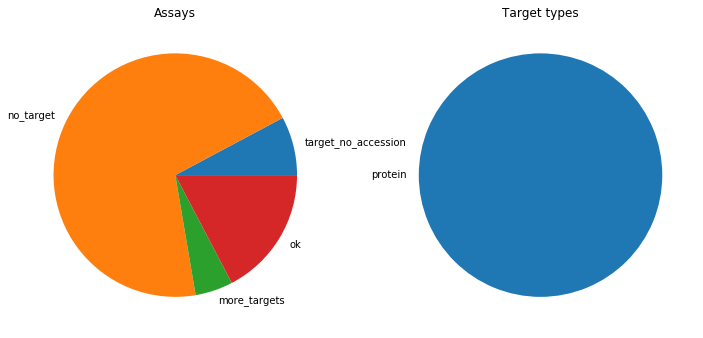

In [19]:
plt.figure(figsize=(12,8))

plt.subplot(121)
plt.title('Assays')
pie_counter(Counter(status_stats))

plt.subplot(122)
plt.title('Target types')
pie_counter(Counter(target_types))

In [ ]:
# remove the files
for batch_filename in tqdm_notebook(batch_sample):
    batch = clean_up_batch(batch_filename)